In [1]:
#@title Import and set ups{ display-mode: "form" }

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

import subprocess
import pymongo
import motor.motor_asyncio
import bson
import bson.json_util
from bson.codec_options import CodecOptions
from bson.raw_bson import RawBSONDocument

import datetime

from scipy import interpolate

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

import gc

tf.enable_v2_behavior()
tf.config.experimental.enable_tensor_float_32_execution(False)
print("TensorFloat-32: " + str(tf.config.experimental.tensor_float_32_execution_enabled()))

TensorFloat-32: False


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [7]:
def fetch_docs(cursor, docs, batch_size, converter=lambda x: x):
    idx = 0
    for val in cursor: 
        try:
            docs.append(converter(val))
        except Exception as e:
            print(val)
            print(e)
        if not idx < batch_size - 1:
            break
        idx+=1

In [8]:
 host = subprocess.check_output(['ip', '-4', 'route', 'show', 'default']).decode().split(' ')[2]
 #client = motor.motor_asyncio.AsyncIOMotorClient('mongodb://connect:cryptoanalyzer%21@' + host + ':27019/?connectTimeoutMS=10000&authSource=MarketData&authMechanism=SCRAM-SHA-1')
 client = pymongo.MongoClient('mongodb://connect:cryptoanalyzer%21@' + host + ':27020/?connectTimeoutMS=10000&authSource=MarketData&authMechanism=SCRAM-SHA-1')

In [9]:
codec_options=CodecOptions(document_class=RawBSONDocument)

db = client.MarketData
#mongoData = db.get_collection("ResultMarketData", codec_options=codec_options)
mongoData = db.get_collection("ResultMarketData")


In [10]:
#data_calls = mongoData.distinct("call")
#data_exchanges = mongoData.distinct("exchange")
#data_symbols = mongoData.distinct("args.symbol")

In [11]:
batch_size = 1000
query = {}
query["result_timestamp"] = {
    "$gte": "2018-09-01T00:00:23.373405"
}
query["exchange"] = "coinbasepro"
#query["call"] = "fetch_order_book"
query["call"] = "fetch_ticker"
query["args.symbol"] = "BTC/USD"

data_cursor = mongoData.find(query).batch_size(batch_size)
source_docs=[]

In [12]:
%time fetch_docs(data_cursor, source_docs, batch_size)

CPU times: user 34.9 ms, sys: 0 ns, total: 34.9 ms
Wall time: 1.72 s


In [13]:
source_docs[0]

{'_id': ObjectId('5b89d781818563000821ef7f'),
 'call': 'fetch_ticker',
 'args': {'symbol': 'BTC/USD'},
 'result': {'symbol': 'BTC/USD',
  'average': None,
  'last': 7022.49,
  'vwap': None,
  'change': None,
  'quoteVolume': None,
  'askVolume': None,
  'previousClose': None,
  'datetime': '2018-09-01T00:04:15.401Z',
  'high': None,
  'low': None,
  'percentage': None,
  'ask': 7022.5,
  'bidVolume': None,
  'bid': 7022.49,
  'baseVolume': 7832.18519257,
  'close': 7022.49,
  'open': None,
  'timestamp': 1535760255401,
  'info': {'volume': '7832.18519257',
   'trade_id': 49964055,
   'size': '0.24480248',
   'price': '7022.49000000',
   'ask': '7022.5',
   'time': '2018-09-01T00:04:15.401000Z',
   'bid': '7022.49'}},
 'result_timestamp': '2018-09-01T00:04:17.631862',
 'exchange': 'coinbasepro'}

In [14]:
def convert_ticker(ticker_result):
    return np.array([ticker_result['result']['timestamp'], 
                    ticker_result['result']['last'], 
                    ticker_result['result']['baseVolume'] if ticker_result['result']['baseVolume'] else ticker_result['result']['quoteVolume'], 
                    ticker_result['result']['bid'], 
                    ticker_result['result']['ask']], dtype=np.float64)

In [15]:
batch_size = 100
query = {}
query["result_timestamp"] = {
    "$gte": "2018-09-01T00:00:23.373405"
}
query["exchange"] = "coinbasepro"
query["call"] = "fetch_ticker"
query["args.symbol"] = "BTC/USD"

data_cursor = mongoData.find(query).batch_size(batch_size)

def load_ticker(batch_size, data_cursor, count):        
    ticker_series = np.zeros([1])
    for i in range(0, count):
        print(f"{i+1}/{count}")
        ticker=[]
        %time fetch_docs(data_cursor, ticker, batch_size, convert_ticker)
        if ticker:
            tmp = np.stack(ticker)
            if ticker_series.any():
                ticker_series = np.concatenate((ticker_series, tmp), axis=0)
            else:
                ticker_series = tmp
        else:
            break
    return ticker_series
ticker_series = load_ticker(batch_size, data_cursor, 2)

1/2
CPU times: user 7.75 ms, sys: 0 ns, total: 7.75 ms
Wall time: 155 ms
2/2
CPU times: user 3.81 ms, sys: 0 ns, total: 3.81 ms
Wall time: 156 ms


In [16]:
time_stamps = pd.to_datetime(ticker_series[:,0]*1000000)
ticker_df = pd.DataFrame(data=ticker_series[:,1:], index=time_stamps, columns=['Price', 'Volume', 'Bid', 'Ask'])
ticker_table = pa.Table.from_pandas(ticker_df)

In [17]:
batch_size = 300
query = {}
query["result_timestamp"] = {
    #"$gte": "2018-09-01T00:00:00.000000"
    "$gte": "2019-10-06T00:00:00.000000"
}
query["exchange"] = "coinbasepro"
#query["exchange"] = "coinmarketcap"
#query["exchange"] = "bitmex"
#query["exchange"] = "kraken"
#query["exchange"] = "gdax"
query["call"] = "fetch_ticker"
query["args.symbol"] = "BTC/USD"

data_cursor = mongoData.find(query).batch_size(batch_size)

def load_ticker_parquet():
    for i in range(0,1000):
        ticker_series = load_ticker(batch_size, data_cursor, 100)
        if not ticker_series.any():
            break
        time_stamps = pd.to_datetime(ticker_series[:,0].astype('int64')*1000000)
        ticker_df = pd.DataFrame(data=ticker_series[:,1:], 
            index=time_stamps, columns=['Price', 'Volume', 'Bid', 'Ask'])
        ticker_df["dt"] = time_stamps.date
        ticker_table = pa.Table.from_pandas(ticker_df, preserve_index=True)
        del ticker_df
        gc.collect()
        pq.write_to_dataset(ticker_table, 
            root_path=f'/data/ticker_{query["exchange"]}_{i:04d}', partition_cols=['dt'], partition_filename_cb=lambda k: f"{{}}-{i:04d}.parquet".format(k[0]))
        gc.collect()
load_ticker_parquet()

1/100
CPU times: user 109 ms, sys: 1.4 ms, total: 111 ms
Wall time: 2.19 s
2/100
CPU times: user 16.3 ms, sys: 2.43 ms, total: 18.7 ms
Wall time: 2.04 s
3/100
CPU times: user 17.4 ms, sys: 1.52 ms, total: 18.9 ms
Wall time: 2.5 s
4/100
CPU times: user 14.3 ms, sys: 4.09 ms, total: 18.3 ms
Wall time: 2.4 s
5/100
CPU times: user 5.43 ms, sys: 3.93 ms, total: 9.36 ms
Wall time: 2.49 s
6/100
CPU times: user 7.62 ms, sys: 336 µs, total: 7.95 ms
Wall time: 2.31 s
7/100
CPU times: user 8.44 ms, sys: 0 ns, total: 8.44 ms
Wall time: 2.28 s
8/100
CPU times: user 7.16 ms, sys: 802 µs, total: 7.96 ms
Wall time: 2.54 s
9/100
CPU times: user 8.66 ms, sys: 0 ns, total: 8.66 ms
Wall time: 2.63 s
10/100
CPU times: user 9.68 ms, sys: 2.13 ms, total: 11.8 ms
Wall time: 2.25 s
11/100
CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 3.6 s
12/100
CPU times: user 16.5 ms, sys: 1.01 ms, total: 17.5 ms
Wall time: 3.39 s
13/100
CPU times: user 11.5 ms, sys: 7.34 ms, total: 18.8 ms
Wall time: 5.34 s

In [18]:
#ticker_table=pq.read_table('/data/ticker.parquet')
ticker_dataset = ds.dataset('/data/ticker', format="parquet", partitioning="hive")
ticker_table = ticker_dataset.to_table()

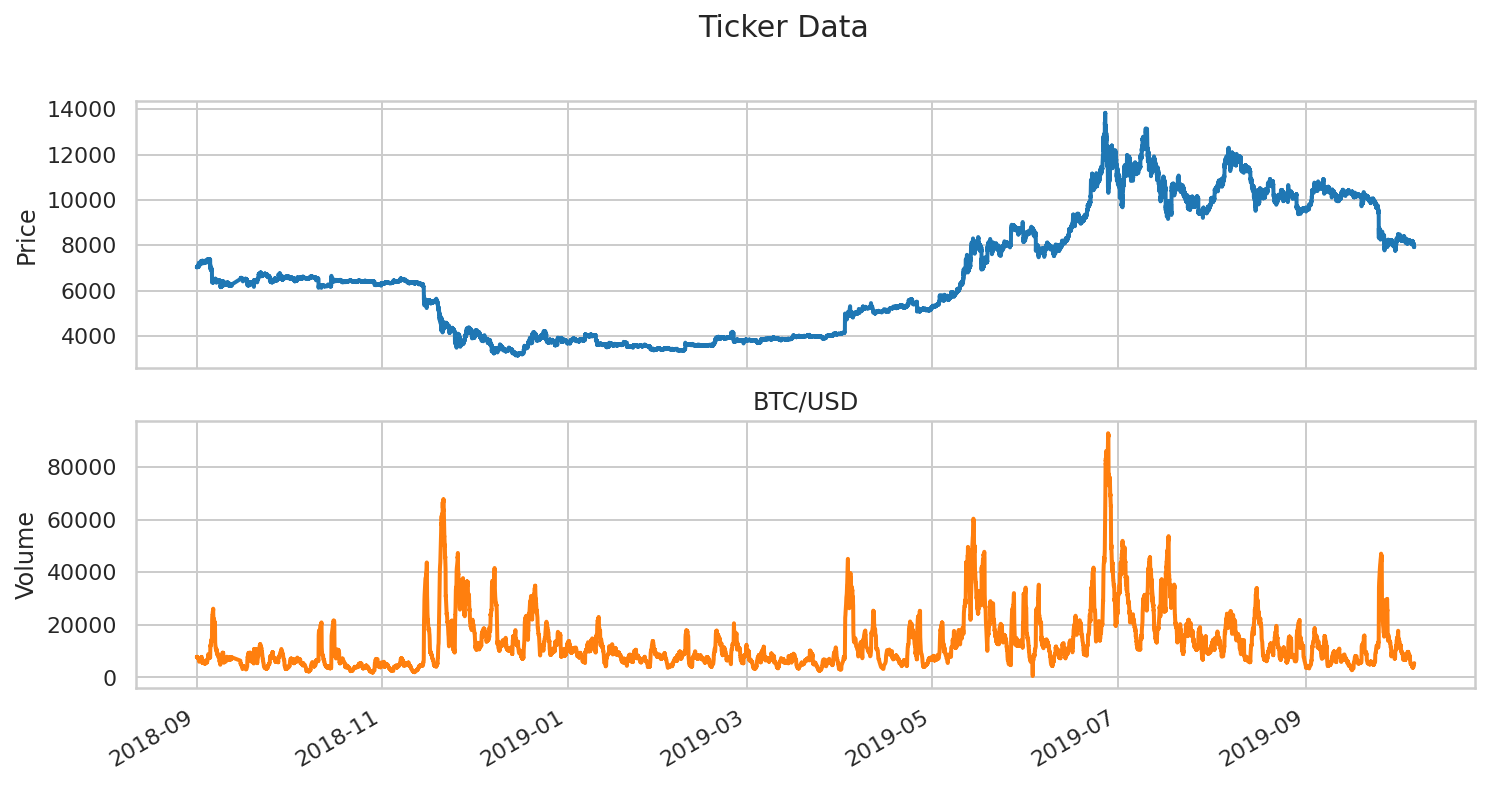

In [19]:

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(ticker_table['__index_level_0__'], ticker_table['Price'], lw=2, label="training data")
ax.set_ylabel("Price")

ax = fig.add_subplot(2, 1, 2)

ax.plot(ticker_table['__index_level_0__'], ticker_table['Volume'], lw=2, label="training data", c=c2)
ax.set_ylabel("Volume")
ax.set_title("BTC/USD")
fig.suptitle("Ticker Data",
             fontsize=15)
fig.autofmt_xdate()

In [15]:
batch_size = 1000
query = {}
query["result_timestamp"] = {
    "$gte": "2018-09-01T00:00:23.373405"
}
query["exchange"] = "coinbasepro"
query["call"] = "fetch_order_book"
query["args.symbol"] = "BTC/USD"

data_cursor = mongoData.find(query).batch_size(batch_size)
source_docs=[]

In [16]:
%time fetch_docs(data_cursor, source_docs, batch_size)

CPU times: user 126 ms, sys: 12.9 ms, total: 139 ms
Wall time: 235 ms


In [17]:
source_docs[-1]

{'_id': ObjectId('5b8a5849818563000840ef42'),
 'call': 'fetch_order_book',
 'args': {'symbol': 'BTC/USD'},
 'result': {'datetime': None,
  'asks': [[7052.9, 8.74413552],
   [7054.1, 0.4946],
   [7054.15, 1.0],
   [7054.32, 0.01],
   [7054.76, 0.001],
   [7054.77, 0.00381943],
   [7054.92, 3.5],
   [7054.93, 1.0],
   [7054.96, 3.5],
   [7055.0, 3.5896463],
   [7055.6, 0.00972016],
   [7055.61, 0.001],
   [7056.09, 0.00972016],
   [7056.1, 0.00972016],
   [7056.11, 0.001],
   [7056.15, 0.001],
   [7056.42, 0.114009],
   [7056.61, 2.0199852],
   [7057.0, 7.45972589],
   [7057.09, 0.25],
   [7057.29, 0.001],
   [7058.0, 0.02],
   [7058.35, 0.00388961],
   [7058.4, 0.026],
   [7058.58, 2.0],
   [7058.81, 0.4],
   [7058.85, 0.53552575],
   [7058.93, 0.51182344],
   [7059.17, 1.6],
   [7059.19, 0.001778],
   [7059.3, 0.50004261],
   [7059.46, 0.16412154],
   [7059.53, 0.001],
   [7059.64, 0.0072],
   [7059.73, 0.00501378],
   [7059.95, 0.338902],
   [7059.99, 0.04589662],
   [7060.0, 1.482176

In [18]:
#lob_depthes = np.linspace(0,.005, 1001)
lob_depthes = np.logspace(np.log10(.5e-6),np.log10(.005), 51)

def micro_price(bid, bidvol, ask, askvol):
    return (bid*askvol + ask*bidvol)/(bidvol + askvol)

In [19]:
tmp_doc = source_docs[-1]
tmp = [tmp_doc['result']['timestamp'] if tmp_doc['result']['timestamp'] else pd.to_datetime(tmp_doc['result_timestamp']).to_numpy().astype('datetime64[ms]').astype('float'), 
                    tmp_doc['result']['bids'], 
                    tmp_doc['result']['asks']]
bids=np.array(tmp[1],dtype=np.float64)
bids_volsum=np.cumsum(bids[:,1])
asks=np.array(tmp[2],dtype=np.float64)
asks_volsum=np.cumsum(asks[:,1])
#price = micro_price(bids[0,0],bids[0,1], asks[0,0], asks[0,1])
price = (bids[0,0] + asks[0,0])/2
bids_prices_norm = - lob_depthes + np.log(price)
bids_vol_f = interpolate.interp1d(np.flip(np.log(bids[:,0])), np.flip(bids_volsum), bounds_error=False,
 fill_value=(bids_volsum[-1],0), 
 #kind="previous")
 kind="linear")
bids_volsum_norm = bids_vol_f(bids_prices_norm)
bids_vol_norm=np.diff(bids_volsum_norm, prepend=0)
asks_prices_norm = + lob_depthes + np.log(price)
asks_vol_f = interpolate.interp1d(np.log(asks[:,0]), asks_volsum, bounds_error=False,
 fill_value=(0, asks_volsum[-1]), 
 #kind="next")
 kind="linear")
asks_volsum_norm = asks_vol_f(asks_prices_norm)
asks_vol_norm=np.diff(asks_volsum_norm, prepend=0)

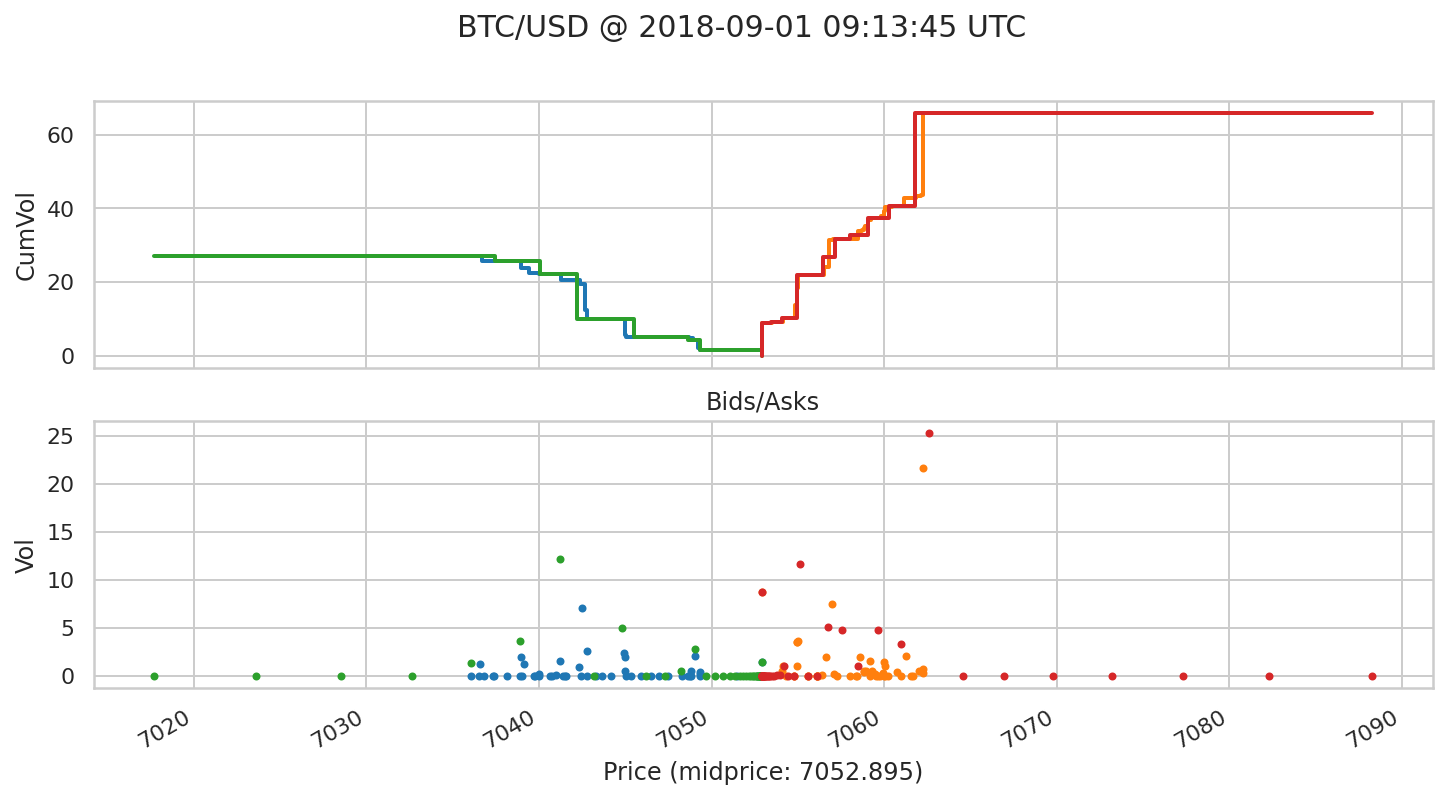

In [20]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.flip(bids[:,0]), np.flip(bids_volsum), lw=2, label="training data", drawstyle='steps-mid')
ax.plot(asks[:,0], asks_volsum, lw=2, label="training data", drawstyle='steps-mid')
ax.plot(np.exp(bids_prices_norm), bids_volsum_norm, lw=2, label="training data", drawstyle='steps-mid')
ax.plot(np.exp(asks_prices_norm), asks_volsum_norm, lw=2, label="training data", drawstyle='steps-mid')
ax.set_ylabel("CumVol")
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.flip(bids[:,0]), np.flip(bids[:,1]), ls='', marker='.', label="training data")
ax.plot(asks[:,0], asks[:,1], ls='', marker='.', label="training data")
ax.plot(np.exp(bids_prices_norm), bids_vol_norm, ls='', marker='.', label="training data")
ax.plot(np.exp(asks_prices_norm), asks_vol_norm, ls='', marker='.', label="training data")
ax.set_ylabel("Vol")
ax.set_xlabel(f"Price (midprice: {price})")
ax.set_title("Bids/Asks")
fig.suptitle(f"BTC/USD @ {pd.to_datetime(int(tmp[0]*1e6)).round('1s')} UTC",
             fontsize=15)
fig.autofmt_xdate()
plt.savefig('LOB_Coinbasepro_discrete.pdf')

In [26]:
#list(map(lambda doc: (len(doc['result']['bids']),len(doc['result']['asks'])), source_docs))
depth=list(map(lambda doc: ([np.log(doc['result']['bids'][-1][0]),np.log(doc['result']['asks'][-1][0])] - np.log((doc['result']['bids'][0][0]+ doc['result']['asks'][0][0])/2)), source_docs))
depthval=np.concatenate(depth)
[np.min(depthval), np.max(depthval)]

[-0.0037060659338852275, 0.003389492985119702]

In [27]:
def micro_price(bid, bidvol, ask, askvol):
    return (bid*askvol + ask*bidvol)/(bidvol + askvol)

def convert_orderbook(order_book_result, lob_depthes):
    timestamp = order_book_result['result']['timestamp'] if order_book_result['result']['timestamp'] else pd.to_datetime(order_book_result['result_timestamp']).to_numpy().astype('datetime64[ms]').astype('float')
    bids=np.array(order_book_result['result']['bids'],dtype=np.float64)
    bids_volsum=np.cumsum(bids[:,1])
    asks=np.array(order_book_result['result']['asks'],dtype=np.float64)
    asks_volsum=np.cumsum(asks[:,1])
    #price = micro_price(bids[0,0],bids[0,1], asks[0,0], asks[0,1])
    price = (bids[0,0] + asks[0,0])/2
    bids_prices_norm = - lob_depthes + np.log(price)
    bids_vol_f = interpolate.interp1d(np.flip(np.log(bids[:,0])), np.flip(bids_volsum), bounds_error=False,
        fill_value=(bids_volsum[-1],0), 
        #kind="previous")
        kind="linear")
    bids_volsum_norm = bids_vol_f(bids_prices_norm)
    bids_vol_norm=np.diff(bids_volsum_norm, prepend=0)
    asks_prices_norm = + lob_depthes + np.log(price)
    asks_vol_f = interpolate.interp1d(np.log(asks[:,0]), asks_volsum, bounds_error=False,
        fill_value=(0, asks_volsum[-1]), 
        #kind="next")
        kind="linear")
    asks_volsum_norm = asks_vol_f(asks_prices_norm)
    asks_vol_norm=np.diff(asks_volsum_norm, prepend=0)
    return np.concatenate([[timestamp, price], bids_vol_norm, asks_vol_norm])


In [28]:
#lob_depthes = np.linspace(0,.005, 1001)
lob_depthes = np.logspace(np.log10(.5e-6),np.log10(.005), 501)

batch_size = 1000
query = {}
query["result_timestamp"] = {
    "$gte": "2018-09-01T00:00:00.000000"
}
query["exchange"] = "coinbasepro"
query["call"] = "fetch_order_book"
query["args.symbol"] = "BTC/USD"

data_cursor = mongoData.find(query).batch_size(batch_size)

def load_orderbook(batch_size, data_cursor, lob_depthes, count):    
    orderbook_series = np.zeros([1])
    for i in range(0,count):
        print(f"{i+1}/{count}")
        orderbook=[]
        %time fetch_docs(data_cursor, orderbook, batch_size, lambda doc: convert_orderbook(doc, lob_depthes))
        if orderbook:
            tmp = np.stack(orderbook)
            if orderbook_series.any():
                orderbook_series = np.concatenate((orderbook_series, tmp), axis=0)
            else:
                orderbook_series = tmp
        else:
            break
    return orderbook_series
orderbook_series = load_orderbook(batch_size, data_cursor, lob_depthes, 2)

1/2
CPU times: user 694 ms, sys: 1.45 ms, total: 695 ms
Wall time: 884 ms
2/2
CPU times: user 685 ms, sys: 6.6 ms, total: 692 ms
Wall time: 1.22 s


In [29]:
time_stamps = pd.to_datetime(orderbook_series[:,0].astype('int64')*1000000)
str_arr = np.frompyfunc("{:.12f}".format, 1,1)
lob_depthes_str = str_arr(np.concatenate((- lob_depthes, lob_depthes)))
orderbook_df = pd.DataFrame(data=orderbook_series[:,1:], index=time_stamps, columns=np.concatenate((['Price'],lob_depthes_str)))
orderbook_df["dt"] = time_stamps.date
orderbook_table = pa.Table.from_pandas(orderbook_df, preserve_index=True)
del orderbook_df
gc.collect()
pq.write_to_dataset(orderbook_table, root_path='/data/orderbook', partition_cols=['dt'], partition_filename_cb=lambda k: f"{{}}-{i:04d}.parquet".format(k[0])
gc.collect()

0

In [30]:
#lob_depthes = np.linspace(0,.005, 1001)
lob_depthes = np.logspace(np.log10(.5e-6),np.log10(.005), 501)

batch_size = 1000
query = {}
query["result_timestamp"] = {
    #"$gte": "2018-09-01T00:00:00.000000"
    "$gte": "2019-10-21T00:00:00.000000"
}
query["exchange"] = "coinbasepro"
#query["exchange"] = "coinmarketcap"
#query["exchange"] = "bitmex"
#query["exchange"] = "kraken"
#query["exchange"] = "gdax"
query["call"] = "fetch_order_book"
query["args.symbol"] = "BTC/USD"

data_cursor = mongoData.find(query).batch_size(batch_size)

def load_orderbook_parquet():
    for i in range(0,1000):
        orderbook_series = load_orderbook(batch_size, data_cursor, lob_depthes, 100)
        if not orderbook_series.any():
            break
        time_stamps = pd.to_datetime(orderbook_series[:,0].astype('int64')*1000000)
        str_arr = np.frompyfunc("{:.12f}".format, 1,1)
        lob_depthes_str = str_arr(np.concatenate((- lob_depthes, lob_depthes)))
        orderbook_df = pd.DataFrame(data=orderbook_series[:,1:], 
            index=time_stamps, columns=np.concatenate((['Price'],lob_depthes_str)))
        orderbook_df["dt"] = time_stamps.date
        orderbook_table = pa.Table.from_pandas(orderbook_df, preserve_index=True)
        del orderbook_df
        gc.collect()
        pq.write_to_dataset(orderbook_table, 
            root_path=f'/data/orderbook_{query["exchange"]}_{i:04d}', partition_cols=['dt'], partition_filename_cb=lambda k: "{}-1.parquet".format(k[0]))
        gc.collect()
load_orderbook_parquet()


1/100
CPU times: user 666 ms, sys: 7.63 ms, total: 674 ms
Wall time: 5.86 s
2/100
CPU times: user 672 ms, sys: 3.26 ms, total: 675 ms
Wall time: 6.28 s
3/100
CPU times: user 575 ms, sys: 3.21 ms, total: 578 ms
Wall time: 6.14 s
4/100
CPU times: user 755 ms, sys: 7.5 ms, total: 762 ms
Wall time: 6.02 s
5/100
CPU times: user 674 ms, sys: 7.25 ms, total: 681 ms
Wall time: 6.69 s
6/100
CPU times: user 565 ms, sys: 7.86 ms, total: 573 ms
Wall time: 5.65 s
7/100
CPU times: user 764 ms, sys: 3.44 ms, total: 768 ms
Wall time: 6.3 s
8/100
CPU times: user 568 ms, sys: 6.9 ms, total: 575 ms
Wall time: 6.45 s
9/100
CPU times: user 767 ms, sys: 0 ns, total: 767 ms
Wall time: 7.38 s
10/100
CPU times: user 561 ms, sys: 12 ms, total: 573 ms
Wall time: 6.07 s
11/100
CPU times: user 761 ms, sys: 10.5 ms, total: 771 ms
Wall time: 6.08 s
12/100
CPU times: user 556 ms, sys: 3.92 ms, total: 560 ms
Wall time: 5.33 s
13/100
CPU times: user 763 ms, sys: 12.1 ms, total: 775 ms
Wall time: 6.64 s
14/100
CPU times

In [31]:
orderbook_dataset = ds.dataset('/data/orderbook', format="parquet", partitioning="hive")

In [32]:
orderbook_dataset.to_table(filter=ds.field('dt') == '2019-01-26').to_pandas()

,Price,-0.000000500000,-0.000000509296,-0.000000518764,-0.000000528409,-0.000000538233,-0.000000548239,-0.000000558432,-0.000000568814,-0.000000579389,...,0.004314892739,0.004395112584,0.004476823828,0.004560054197,0.004644831934,0.004731185807,0.004819145118,0.004908739715,0.005000000000,dt
2019-01-26 00:00:11.849,3562.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-26
2019-01-26 00:00:45.977,3562.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-26
2019-01-26 00:01:26.693,3562.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-26
2019-01-26 00:01:44.881,3562.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-26
2019-01-26 00:02:21.934,3562.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-26 23:57:41.259,3556.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-26
2019-01-26 23:58:06.918,3556.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-26
2019-01-26 23:58:32.834,3556.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-26
2019-01-26 23:59:14.598,3556.595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-26


In [33]:
batches = []
idx=0
for scan_task in orderbook_dataset.scan(columns=['__index_level_0__','Price']):
    for record_batch in scan_task.execute():
        batches.append(record_batch.to_pandas())
        print(f'Batch {idx}')
        idx+=1
orderbook_prices = pd.concat(batches)

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


In [34]:
orderbook_prices

,Price
2018-09-01 00:00:05.311,7013.005
2018-09-01 00:00:35.284,7012.995
2018-09-01 00:01:04.970,7013.005
2018-09-01 00:01:40.193,7022.495
2018-09-01 00:02:15.602,7022.495
...,...
2019-10-21 02:06:03.630,8238.005
2019-10-21 02:06:32.960,8237.315
2019-10-21 02:07:02.973,8234.845
2019-10-21 02:07:32.985,8230.995


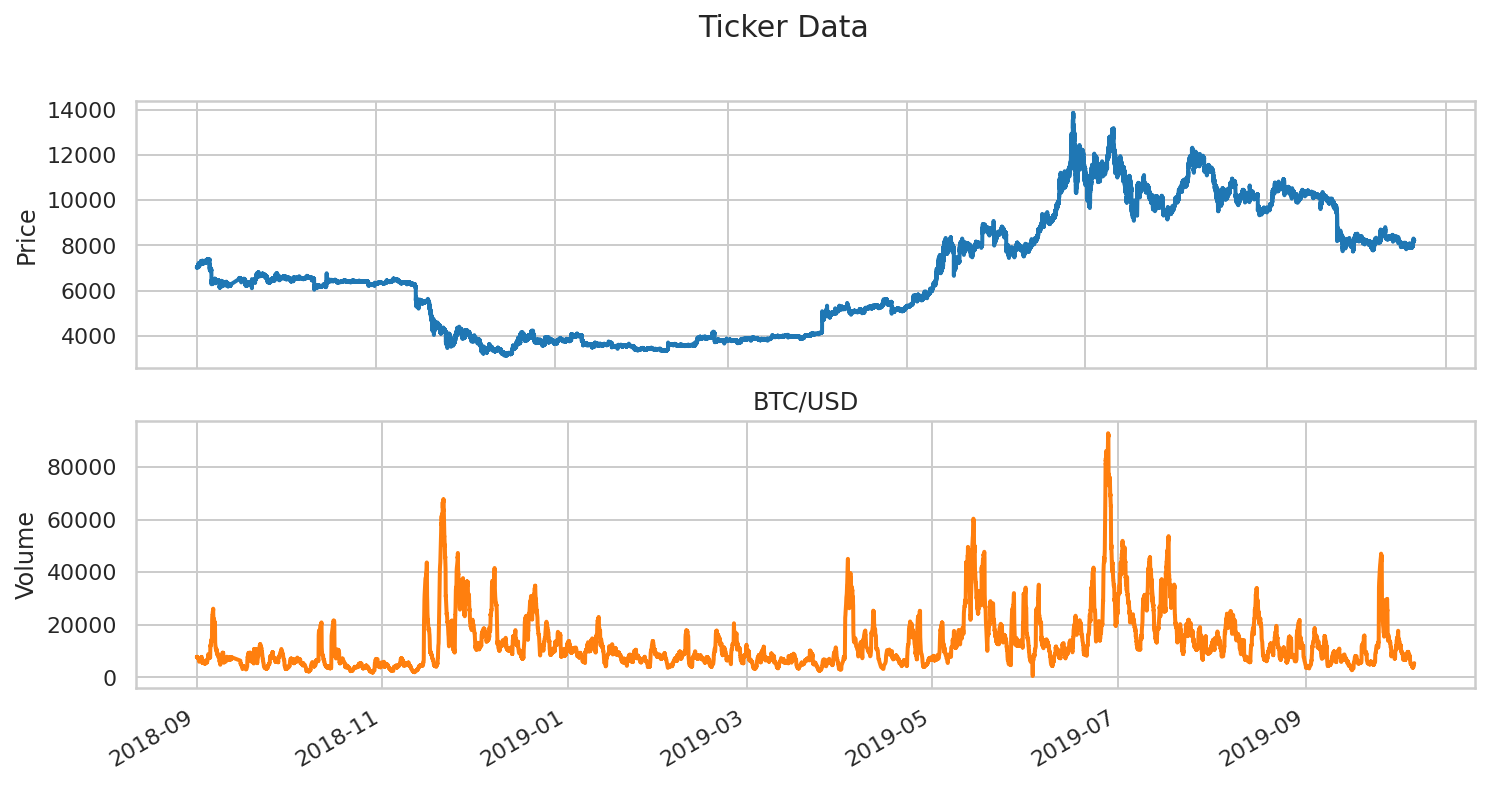

In [35]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(orderbook_prices.index, orderbook_prices['Price'], lw=2, label="training data")
ax.set_ylabel("Price")

ax = fig.add_subplot(2, 1, 2)

ax.plot(ticker_table['__index_level_0__'], ticker_table['Volume'], lw=2, label="training data", c=c2)
ax.set_ylabel("Volume")
ax.set_title("BTC/USD")
fig.suptitle("Ticker Data",
             fontsize=15)
fig.autofmt_xdate()